## The notebook focuses on classifying **Insomnia** using `XG Boost` and analyzing feature importance to understand contributing factors.

### Importing Required Packages

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

import shap

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [10]:
fname = '../Data/dry_eye_disease_parsed.csv'
df0 = pd.read_csv(fname)

%run '../Data/utils.py'
%run '../Data/features_list.py'
%run '../Data/model_params.py'


### Identify categorical columns and apply Label Encoding

In [11]:
df = df0.copy()
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    #print(f'Classes for column {col}:',label_encoders[col].classes_)
    
print(df.columns.tolist())

#Remove columns which have been used to created features
omit_cols = ['systolic', 'diastolic',\
             'sleep_disorder', 'sleep_duration', 'sleep_quality', 'feel_sleepy_during_day', 'wake_up_during_night',\
                 'combined_condition', 'height', 'weight']
df = df.drop(columns=omit_cols)

['gender', 'age', 'sleep_duration', 'sleep_quality', 'stress_level', 'heart_rate', 'daily_steps', 'physical_activity', 'height', 'weight', 'sleep_disorder', 'wake_up_during_night', 'feel_sleepy_during_day', 'caffeine_consumption', 'alcohol_consumption', 'smoking', 'medical_issue', 'ongoing_medication', 'smart_device_before_bed', 'average_screen_time', 'blue-light_filter', 'discomfort_eye-strain', 'redness_in_eye', 'itchiness/irritation_in_eye', 'dry_eye_disease', 'systolic', 'diastolic', 'bp_category', 'insomnia', 'combined_condition', 'bmi']


### Feature Selection and Importance Analysis

The `feature_selection` function analyzes feature importance for a target variable. It uses **XGBoost** to rank features (optionally with hyperparameter tuning via GridSearchCV) and trains Logistic Regression to inspect coefficients. The top 15 features are visualized in a colored bar plot according to their categories, with Logistic Regression coefficients included in the labels.

**Steps:**

1.  **Data Split** 
2.  **Hyperparameter Tuning (Optional)** 
3.  **XGBoost Training** 
4.  **Evaluation** 
5.  **Feature Importance** 
6.  **Logistic Regression** 
7.  **Visualization**


In [12]:
def feature_selection(df, col, best_params=None, random_state = 1205):
    target_col = col 
    y = df[target_col]
    #Drop the target columns, so the rest are feature columns
    X = df.drop(columns=target_col)
    
    # Splitting into training (80%) and testing (20%) sets
    X_train_init, X_test, y_train_init, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Further split: training and validation sets (e.g., 20% of training goes to validation)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_init, y_train_init, test_size=0.2, random_state=random_state
    )
    
    if best_params== None:
        # Define XGBoost model
        model = XGBClassifier(objective='reg:squarederror', random_state=random_state)
        
        param_grid = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.85, 1.0],  
            'lambda': [1,3,5]          
        }
        # Perform Grid Search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters
        best_params = grid_search.best_params_
        
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    best_model = XGBClassifier(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class classification
    recall = recall_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    
    # Evaluate on train set
    y_pred0 = best_model.predict(X_val)
    mse0 = mean_squared_error(y_val, y_pred0)
    acc0 = accuracy_score(y_val, y_pred0)
    f10 = f1_score(y_val, y_pred0, average='weighted')  # Use 'weighted' for multi-class classification
    recall0 = recall_score(y_val, y_pred0, average='weighted')
    precision0 = precision_score(y_val, y_pred0, average='weighted')

    print(f"Mean Squared Error: (Test) {mse * 100:.2f}%, (Train) {mse0 * 100:.2f}%")
    print(f"Accuracy: (Test) {acc * 100:.2f}%, (Train) {acc0 * 100:.2f}%")
    print(f"Precision: (Test) {precision * 100:.2f}%, (Train) {precision0 * 100:.2f}%")
    print(f"Recall: (Test) {recall * 100:.2f}%, (Train) {recall0 * 100:.2f}%")
    print(f"F1 Score: (Test) {f1 * 100:.2f}%, (Train) {f10 * 100:.2f}%")
    print("-" * 30)
    
    # Feature Importance
    feature_names = X.columns.tolist()
    importance = best_model.feature_importances_
    f_pairs = list(zip(importance, feature_names))
    f_pairs.sort()
    importance_sort, feature_names_sort = zip(*f_pairs)
    
    # Prepare DataFrame for seaborn
    importance_df = pd.DataFrame({
        "Feature": feature_names_sort,
        "Importance": importance_sort,
        "Category": [feature_to_category.get(f, "Other") for f in feature_names_sort]
    })
    
    # Train logistic regression for coefficient inspection
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    logreg = LogisticRegression(max_iter=1000, random_state=random_state)
    logreg.fit(X_scaled, y_train)

    # Map coefficients to feature names
    logreg_coeffs = dict(zip(X.columns, logreg.coef_[0]))  # assumes binary classification
    
    importance_df = importance_df[::-1]
    importance_df = importance_df.head(15)

    # Round and attach logistic regression coefficients to labels
    importance_df["LogRegCoef"] = importance_df["Feature"].map(lambda f: logreg_coeffs.get(f, np.nan))
    
    importance_df["LabelWithCoef"] = importance_df.apply(
        lambda row: f"{format_feature_name(row['Feature'])} ({format_sci_notation(row['LogRegCoef'])})"
        if not np.isnan(row['LogRegCoef']) else format_feature_name(row['Feature']),
        axis=1
    )
    
    # Map colors based on categories
    importance_df["Color"] = importance_df["Category"].map(category_colors).fillna("#7f7f7f")

    # Plot with seaborn
    plt.figure(figsize=(12, 6))

    sns.barplot(
        data=importance_df,
        y="LabelWithCoef",
        x="Importance",
        palette=importance_df.set_index("LabelWithCoef")["Color"].to_dict(),
        order=importance_df["LabelWithCoef"]
    )

    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.xscale("log")
 
    legend_patches = [
        Patch(color=color, label=cat.replace("_", " ").title()) for cat, color in category_colors.items()
    ]
    plt.legend(handles=legend_patches, title="Feature Categories", bbox_to_anchor=(0.55, 0.6), loc='upper left')

    #plt.tight_layout()
    plt.show()
    plt.clf()

### Feature importance for **Insomnia**

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.85}
Mean Squared Error: (Test) 46.88%, (Train) 46.91%
Accuracy: (Test) 53.12%, (Train) 53.09%
Precision: (Test) 52.78%, (Train) 46.13%
Recall: (Test) 53.12%, (Train) 53.09%
F1 Score: (Test) 37.33%, (Train) 37.37%
------------------------------


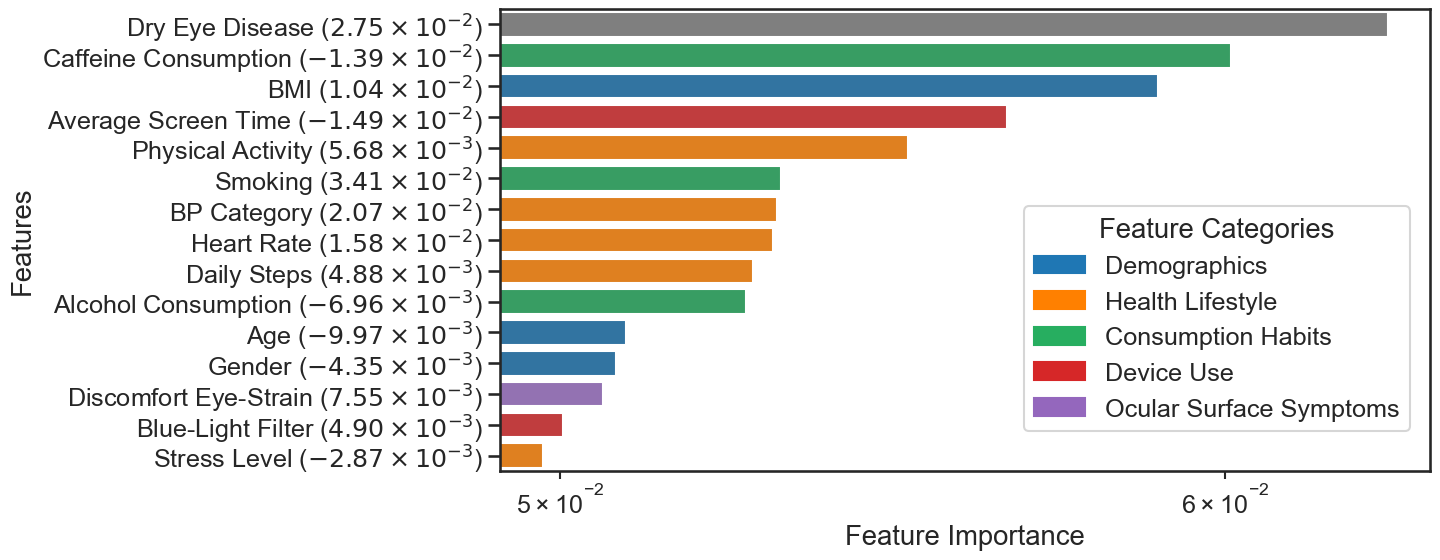

<Figure size 640x480 with 0 Axes>

In [13]:
best_p = {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.85}
feature_selection(df, 'insomnia', best_params=best_p)

### Feature importance for **Insomnia** when `'age'<35`

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.66%, (Train) 47.58%
Accuracy: (Test) 53.34%, (Train) 52.42%
Precision: (Test) 50.37%, (Train) 44.40%
Recall: (Test) 53.34%, (Train) 52.42%
F1 Score: (Test) 38.73%, (Train) 37.81%
------------------------------


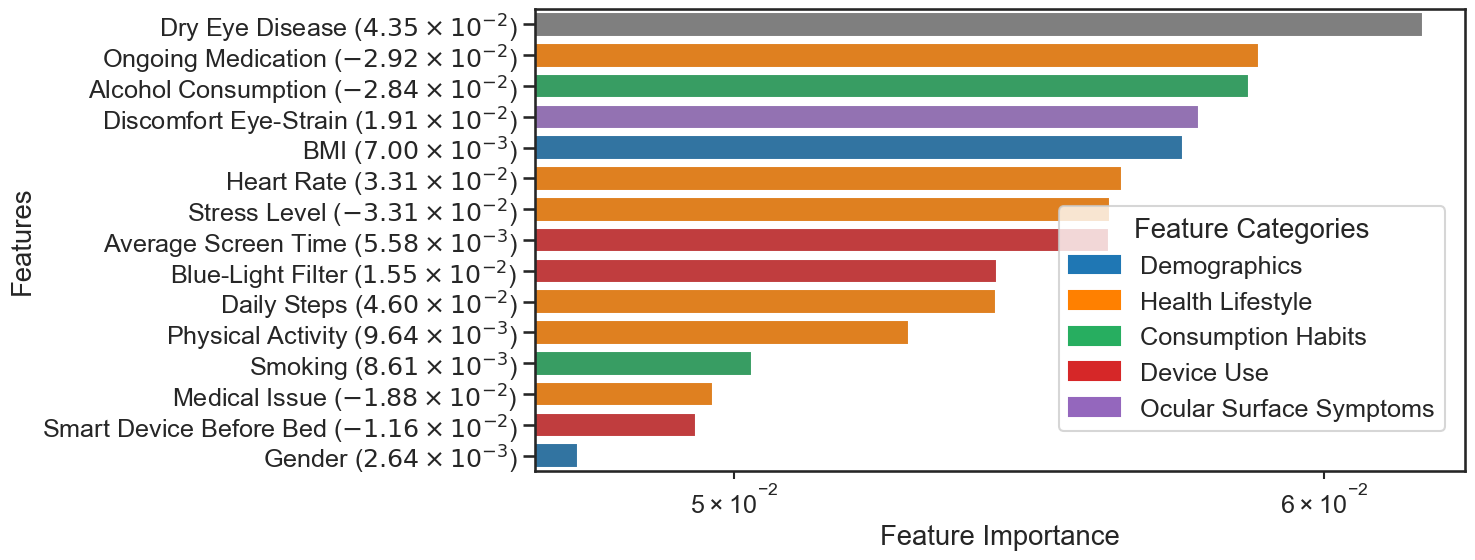

<Figure size 640x480 with 0 Axes>

In [14]:
best_p = {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
df1 = df[df['age']<35]
df1 = df1.drop(columns='age')
feature_selection(df1, 'insomnia', best_params=best_p)

### Feature importance for **Insomnia** when `'age'>=35`

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
Mean Squared Error: (Test) 47.13%, (Train) 49.15%
Accuracy: (Test) 52.87%, (Train) 50.85%
Precision: (Test) 48.74%, (Train) 45.33%
Recall: (Test) 52.87%, (Train) 50.85%
F1 Score: (Test) 39.43%, (Train) 36.89%
------------------------------


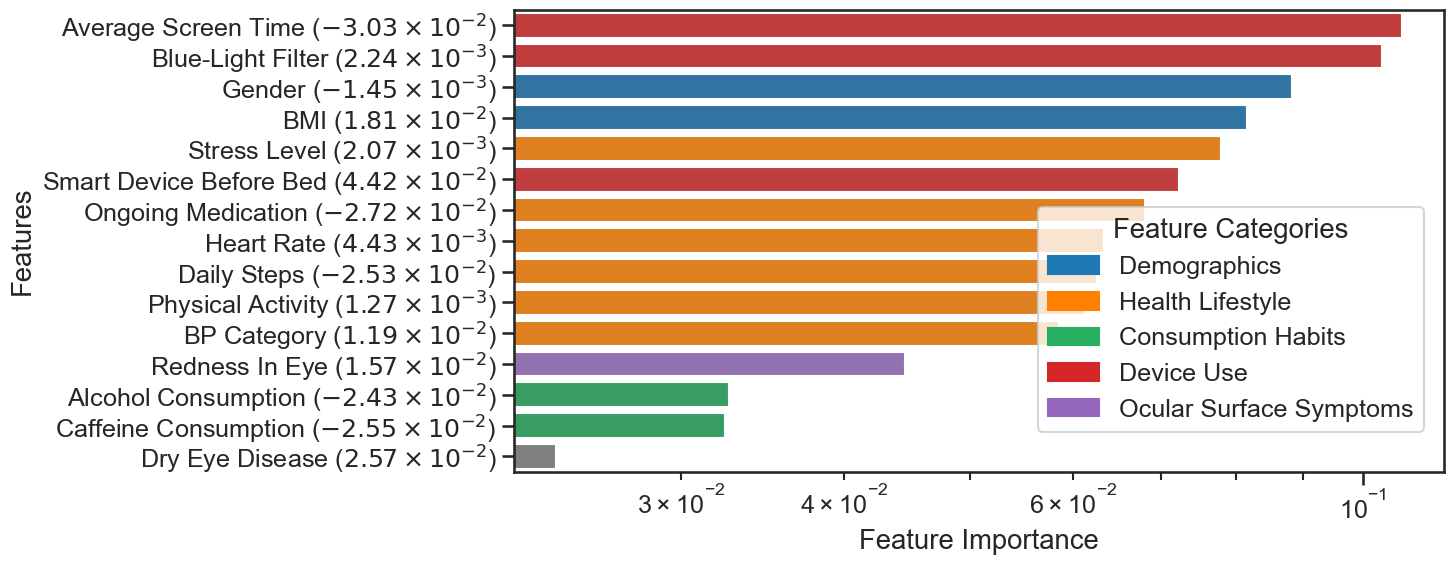

<Figure size 640x480 with 0 Axes>

In [15]:
best_p = {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
df1 = df[df['age']>=35]
df1 = df1.drop(columns='age')
feature_selection(df1, 'insomnia', best_params=best_p)


### Feature importance for **Insomnia** when `'physical_activity'<Mean (90 mins)`

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.85}
Mean Squared Error: (Test) 48.84%, (Train) 45.29%
Accuracy: (Test) 51.16%, (Train) 54.71%
Precision: (Test) 45.54%, (Train) 53.91%
Recall: (Test) 51.16%, (Train) 54.71%
F1 Score: (Test) 38.25%, (Train) 42.29%
------------------------------


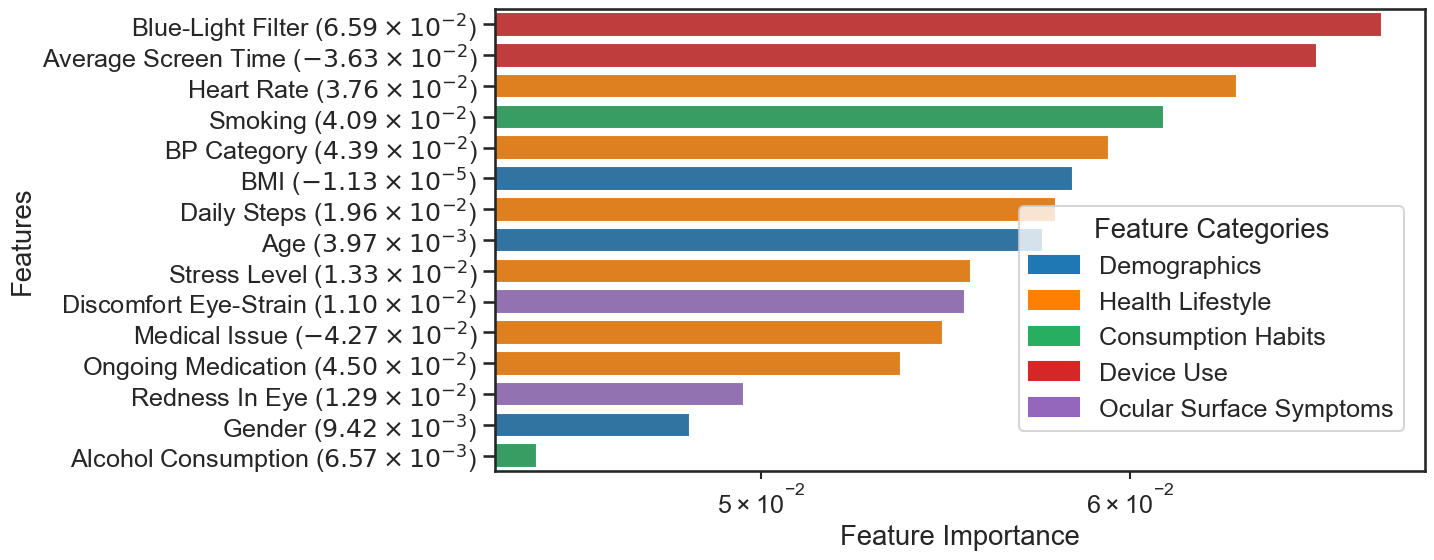

<Figure size 640x480 with 0 Axes>

In [16]:
best_p = {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.85}
df1 = df[df['physical_activity']<90]
df1 = df1.drop(columns='physical_activity')
feature_selection(df1, 'insomnia', best_params=best_p)

### Feature importance for **Insomnia** when `'physical_activity'>=Mean (90 mins)`

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
Mean Squared Error: (Test) 46.81%, (Train) 47.47%
Accuracy: (Test) 53.19%, (Train) 52.53%
Precision: (Test) 28.29%, (Train) 27.59%
Recall: (Test) 53.19%, (Train) 52.53%
F1 Score: (Test) 36.93%, (Train) 36.18%
------------------------------


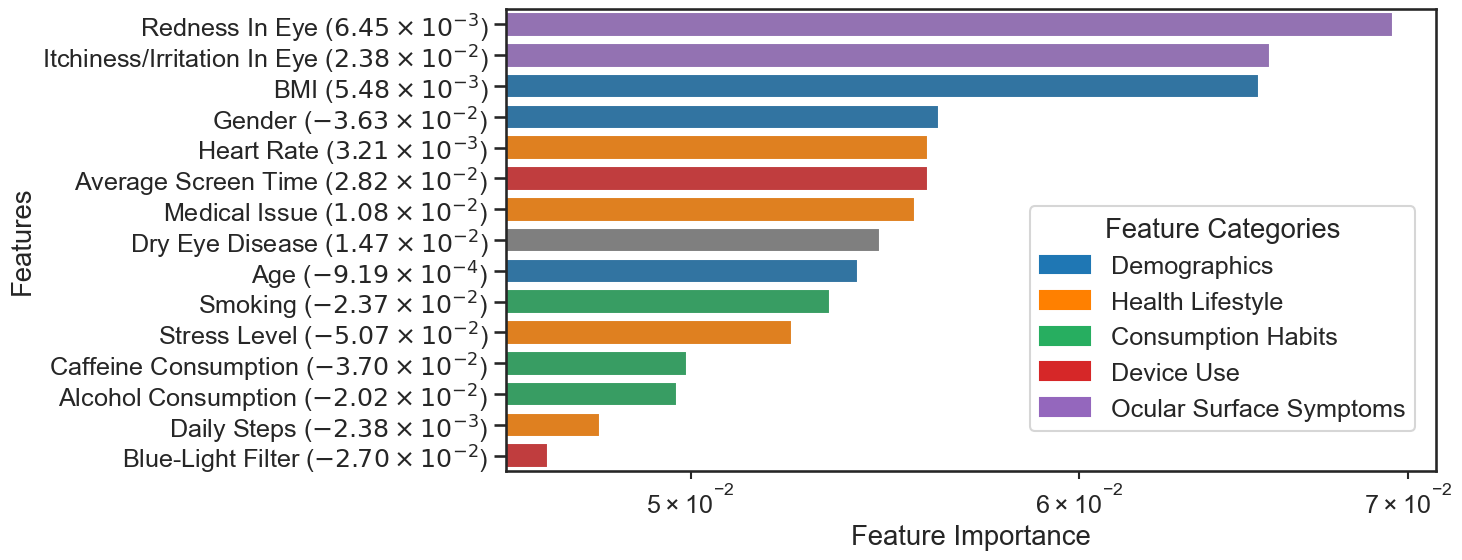

<Figure size 640x480 with 0 Axes>

In [17]:
best_p = {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
df1 = df[df['physical_activity']>=90]
df1 = df1.drop(columns='physical_activity')
feature_selection(df1, 'insomnia', best_params=best_p)

### Feature importance for **Insomnia** when `'gender'=Male`

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
Mean Squared Error: (Test) 48.06%, (Train) 48.35%
Accuracy: (Test) 51.94%, (Train) 51.65%
Precision: (Test) 26.98%, (Train) 26.68%
Recall: (Test) 51.94%, (Train) 51.65%
F1 Score: (Test) 35.52%, (Train) 35.18%
------------------------------


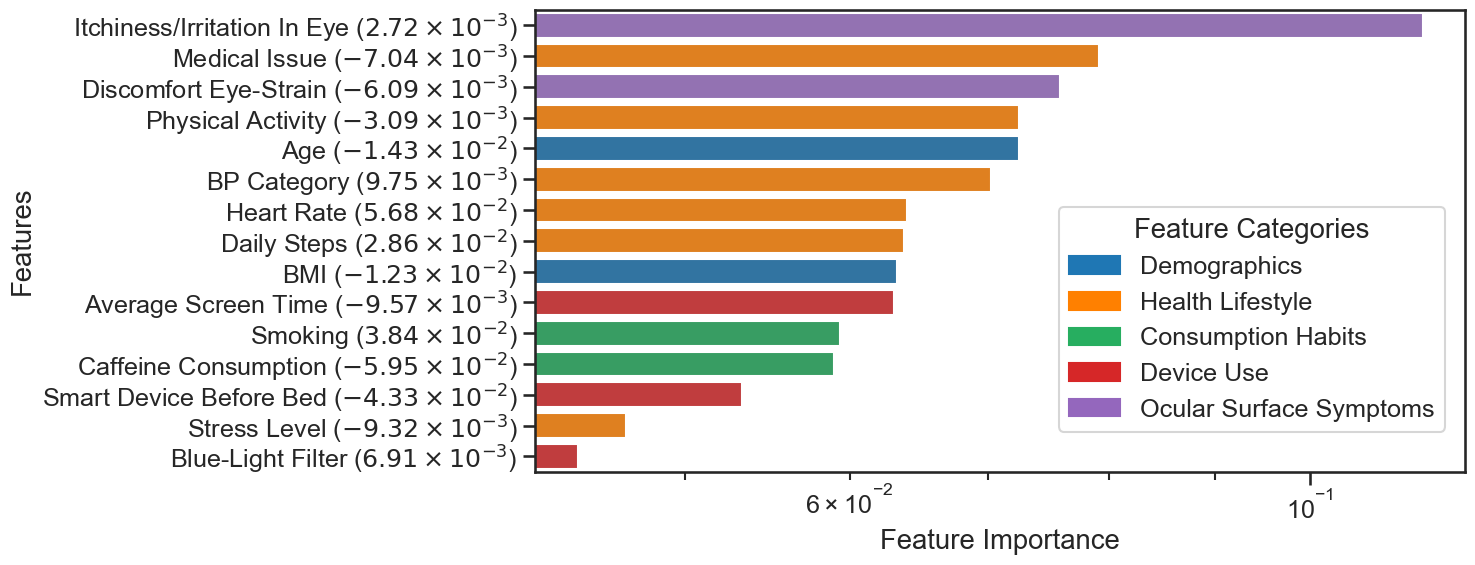

<Figure size 640x480 with 0 Axes>

In [18]:
best_p = {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
df1 = df[df['gender']==1]
df1 = df1.drop(columns='gender')
feature_selection(df1, 'insomnia', best_params=best_p)

### Feature importance for **Insomnia** when `'gender'=Female`

Best Parameters: {'lambda': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 47.27%, (Train) 46.93%
Accuracy: (Test) 52.73%, (Train) 53.07%
Precision: (Test) 27.81%, (Train) 28.22%
Recall: (Test) 52.73%, (Train) 53.07%
F1 Score: (Test) 36.41%, (Train) 36.84%
------------------------------


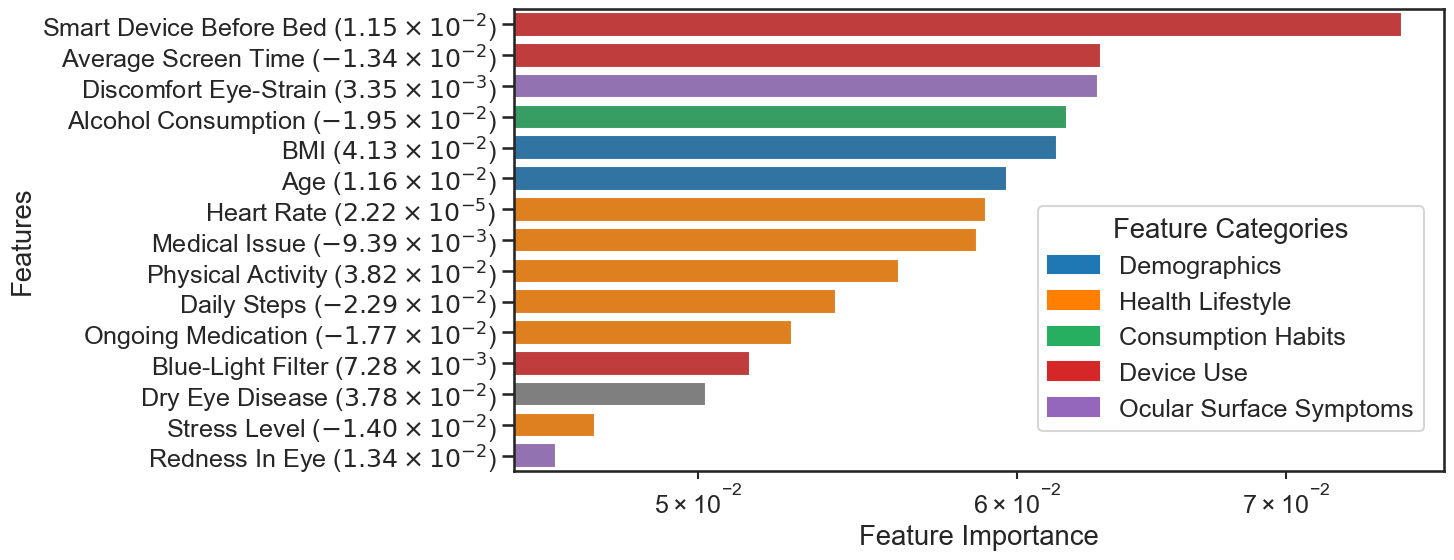

<Figure size 640x480 with 0 Axes>

In [19]:
best_p = {'lambda': 5, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
df1 = df[df['gender']==0]
df1 = df1.drop(columns='gender')
feature_selection(df1, 'insomnia', best_params=best_p)

### Feature Importance with Category and Logistic Regression Coefficients

For a given **feature category**, the `feature_category` function identifies and visualizes important features using XGBoost, and analyzes the direction of their influence using Logistic Regression coefficients.

**Process:**

1.  **Split Data** 
2.  **Tune XGBoost (Optional)** 
3.  **Train XGBoost** 
4.  **Evaluate** 
5.  **Get Importance** 
6.  **Train Logistic Regression** 
7.  **Format Labels** 
8.  **Categorize & Color** 
9.  **Visualize** 

In [20]:
def feature_category(df, col, best_params=None, random_state=1205):
    target_col = col
    y = df[target_col]
    X = df.drop(columns=target_col)

    # Splitting into training (80%) and testing (20%) sets
    X_train_init, X_test, y_train_init, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Further split: training and validation sets (e.g., 20% of training goes to validation)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_init, y_train_init, test_size=0.2, random_state=random_state
    )
     
    if best_params== None:
        # Define XGBoost model
        model = XGBClassifier(objective='reg:squarederror', random_state=random_state)
        
        param_grid = {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.7, 0.85, 1.0],  
            'lambda': [1,3,5]          
        }
        # Perform Grid Search
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                cv=3, scoring='neg_mean_squared_error', n_jobs=-1, verbose=0)
        grid_search.fit(X_train, y_train)
        
        # Get best parameters
        best_params = grid_search.best_params_
        
    print("Best Parameters:", best_params)
    
    # Train final model with best parameters
    best_model = XGBClassifier(**best_params, random_state=random_state)
    best_model.fit(X_train, y_train)

    # Evaluate
    y_pred_test = best_model.predict(X_test)
    y_pred_train = best_model.predict(X_val)

    print(f"Mean Squared Error: (Test) {mean_squared_error(y_test, y_pred_test) * 100:.2f}%, (Train) {mean_squared_error(y_val, y_pred_train) * 100:.2f}%")
    print(f"Accuracy: (Test) {accuracy_score(y_test, y_pred_test) * 100:.2f}%, (Train) {accuracy_score(y_val, y_pred_train) * 100:.2f}%")
    print(f"Precision: (Test) {precision_score(y_test, y_pred_test, average='weighted') * 100:.2f}%, (Train) {precision_score(y_val, y_pred_train, average='weighted') * 100:.2f}%")
    print(f"Recall: (Test) {recall_score(y_test, y_pred_test, average='weighted') * 100:.2f}%, (Train) {recall_score(y_val, y_pred_train, average='weighted') * 100:.2f}%")
    print(f"F1 Score: (Test) {f1_score(y_test, y_pred_test, average='weighted') * 100:.2f}%, (Train) {f1_score(y_val, y_pred_train, average='weighted') * 100:.2f}%")
    print("-" * 30)

    # Feature Importance
    importance = best_model.feature_importances_
    feature_names = X.columns.tolist()
    f_pairs = sorted(zip(importance, feature_names))
    importance_sort, feature_names_sort = zip(*f_pairs)

    importance_df = pd.DataFrame({
        "Feature": feature_names_sort,
        "Importance": importance_sort
    })
    
    # Standardize features for better interpretation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    # Fit logistic regression
    logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=random_state)
    logreg.fit(X_scaled, y_train)
    # Map features to coefficients
    coefficients = dict(zip(X.columns, logreg.coef_[0]))

    def format_sci_notation(val):
        if np.isnan(val):
            return ""
        exponent = int(np.floor(np.log10(abs(val)))) if val != 0 else 0
        base = val / 10**exponent if val != 0 else 0
        return r"${:.2f} \times 10^{{{}}}$".format(base, exponent)

    
    importance_df["LogRegCoeff"] = importance_df["Feature"].map(lambda f: coefficients.get(f, np.nan))
    
    importance_df["LabelWithCorr"] = importance_df.apply(
        lambda row: f"{format_feature_name(row['Feature'])} ({format_sci_notation(row['LogRegCoeff'])})"
        if not np.isnan(row['LogRegCoeff']) else format_feature_name(row['Feature']),
        axis=1
    )

    # Add category and color
    importance_df["Category"] = importance_df["Feature"].map(lambda f: feature_to_category.get(f, "Other"))
    importance_df["Color"] = importance_df["Category"].map(category_colors).fillna("#7f7f7f")

    # Sort and select top 15
    importance_df = importance_df.sort_values("Importance", ascending=False).head(15)

    # Plot
    plt.figure(figsize=(8, 3))
    sns.barplot(
        data=importance_df,
        y="LabelWithCorr",
        x="Importance",
        palette=importance_df.set_index("LabelWithCorr")["Color"].to_dict(),
        order=importance_df["LabelWithCorr"]
    )

    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.xscale("linear")
    plt.tight_layout()
    plt.show()
    plt.clf()

### Fixing a **feature category**, determine and plot feature importance keeping **Insomnia** as target

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.88%, (Train) 46.81%
Accuracy: (Test) 53.12%, (Train) 53.19%
Precision: (Test) 52.89%, (Train) 49.78%
Recall: (Test) 53.12%, (Train) 53.19%
F1 Score: (Test) 37.29%, (Train) 37.58%
------------------------------


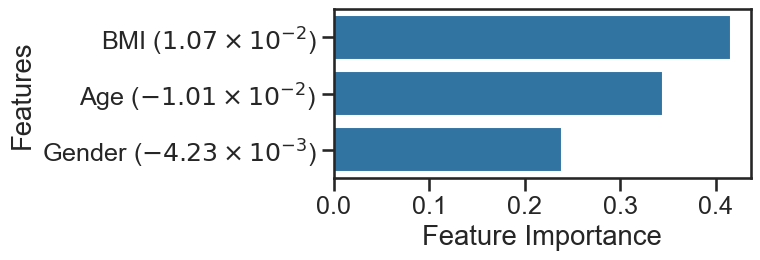

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.85}
Mean Squared Error: (Test) 46.92%, (Train) 46.78%
Accuracy: (Test) 53.08%, (Train) 53.22%
Precision: (Test) 46.95%, (Train) 48.39%
Recall: (Test) 53.08%, (Train) 53.22%
F1 Score: (Test) 36.91%, (Train) 37.16%
------------------------------


<Figure size 640x480 with 0 Axes>

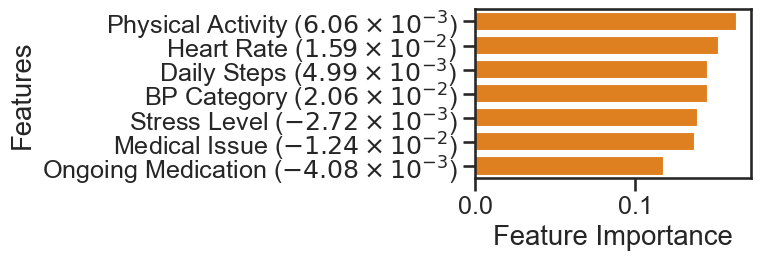

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.90%, (Train) 46.75%
Accuracy: (Test) 53.10%, (Train) 53.25%
Precision: (Test) 28.20%, (Train) 28.36%
Recall: (Test) 53.10%, (Train) 53.25%
F1 Score: (Test) 36.83%, (Train) 37.01%
------------------------------


<Figure size 640x480 with 0 Axes>

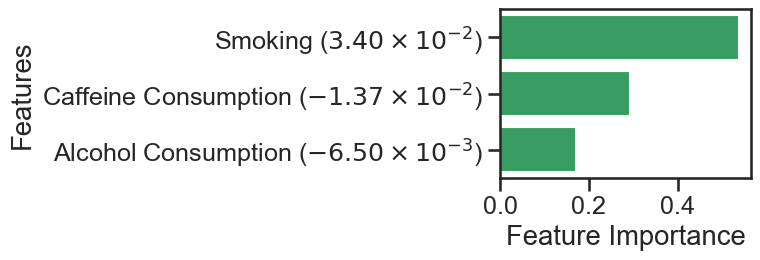

Best Parameters: {'lambda': 3, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 47.02%, (Train) 46.66%
Accuracy: (Test) 52.98%, (Train) 53.34%
Precision: (Test) 42.60%, (Train) 59.55%
Recall: (Test) 52.98%, (Train) 53.34%
F1 Score: (Test) 36.95%, (Train) 37.38%
------------------------------


<Figure size 640x480 with 0 Axes>

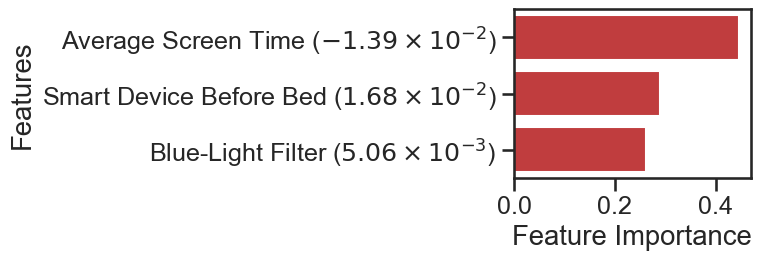

Best Parameters: {'lambda': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.7}
Mean Squared Error: (Test) 46.90%, (Train) 46.75%
Accuracy: (Test) 53.10%, (Train) 53.25%
Precision: (Test) 28.20%, (Train) 28.36%
Recall: (Test) 53.10%, (Train) 53.25%
F1 Score: (Test) 36.83%, (Train) 37.01%
------------------------------


<Figure size 640x480 with 0 Axes>

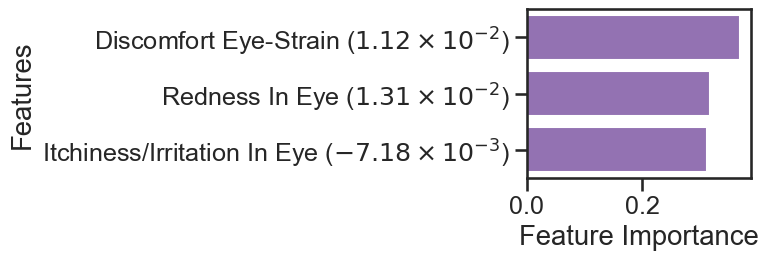

<Figure size 640x480 with 0 Axes>

In [21]:
for cat in category_map:
    ll = category_map[cat].copy()
    ll.extend(list(["insomnia"]))
    df1 = df[ll]
    best_p = {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
    feature_category(df1, 'insomnia', best_params=None)